In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import scanpy as sc
from anndata import AnnData
from sklearn.preprocessing import StandardScaler,LabelEncoder
from scipy.sparse import spmatrix
from datetime import datetime
import sys
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import scipy.sparse as sp
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold, cross_validate
from scipy.stats.contingency import crosstab
import seaborn as sns
import matplotlib.pyplot as plt

/home/inf-39-2024/.conda/envs/scseq/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [ ]:
# Load the datasets
path_file = '8_Classifiers/Data/Input/adata_myeloid.h5ad'

adata = sc.read_h5ad(path_file)
adata

AnnData object with n_obs × n_vars = 182934 × 10
    obs: 'UMAP1', 'UMAP2', 'leiden_0.4', 'leiden_0.6', 'leiden_1.0', 'leiden_1.4', 'cell_type', 'louvain_None', 'louvain_0.4', 'louvain_0.6', 'louvain_1.0', 'louvain_1.4', 'myeloid_cell_type', 'myeloid_louvain_None', 'myeloid_louvain_0.4', 'myeloid_louvain_0.6', 'myeloid_louvain_1.0', 'myeloid_louvain_1.4', 'myeloid_louvain_1.6', 'myeloid_louvain_1.8', 'myeloid_louvain_2.0', 'myeloid_louvain_1.2', 'predicted_type_1.0', 'predicted_type_1.2', 'predicted_type_1.4', 'predicted_type_1.6', 'predicted_type_1.8', 'predicted_type_2.0'
    var: 'gene_id', 'gene_name'
    uns: 'cell_type_colors', 'leiden_0.4', 'leiden_0.4_colors', 'leiden_0.6', 'leiden_0.6_colors', 'leiden_1.0', 'leiden_1.0_colors', 'leiden_1.4', 'leiden_1.4_colors', 'log1p', 'louvain_0.4', 'louvain_0.6', 'louvain_1.0', 'louvain_1.4', 'louvain_None', 'myeloid_cell_type_colors', 'myeloid_louvain_0.4', 'myeloid_louvain_0.4_colors', 'myeloid_louvain_0.6', 'myeloid_louvain_0.6_colors',

In [3]:
# Set X and Y
X = adata.X
Y = adata.obs['myeloid_cell_type']
le = LabelEncoder()
Y_encoded = le.fit_transform(Y)

In [10]:
# Split into traiing and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_encoded, test_size=0.1, stratify=Y_encoded, random_state=42)

In [ ]:
# Create an array of indices for all cells
all_indices = np.arange(X.shape[0])

# Split indices, keeping track of which are train/test
train_idx, test_idx = train_test_split(
    all_indices,
    test_size=0.1,
    stratify=Y_encoded,
    random_state=42)

# Use indices to subset X and Y
X_train, X_test = X[train_idx], X[test_idx]
Y_train, Y_test = Y_encoded[train_idx], Y_encoded[test_idx]

In [ ]:
print('Original class distribution:\n', pd.Series(Y).value_counts(normalize=True))
print('\nTraining class distribution:\n', pd.Series(Y_train).value_counts(normalize=True))
print('\nTraining class counts:\n', pd.Series(Y_train).value_counts())

Original class distribution:
 myeloid_cell_type
Macrophages    0.880301
Monocytes      0.064083
Rest           0.029978
Neutrophils    0.018652
DCs            0.006937
Mast Cells     0.000049
Name: proportion, dtype: float64

Training class distribution:
 myeloid_cell_type
Macrophages    0.880302
Monocytes      0.064085
Rest           0.029974
Neutrophils    0.018653
DCs            0.006936
Mast Cells     0.000049
Name: proportion, dtype: float64

Training class counts:
 myeloid_cell_type
Macrophages    144933
Monocytes       10551
Rest             4935
Neutrophils      3071
DCs              1142
Mast Cells          8
Name: count, dtype: int64


In [ ]:
def fit_and_score(estimator, X_train, X_test, Y_train, Y_test):
    estimator.fit(X_train, Y_train, eval_set=[(X_test, Y_test)])

    train_score = estimator.score(X_train, Y_train)
    test_score = estimator.score(X_test, Y_test)

    return estimator, train_score, test_score


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=94)

clf = xgb.XGBClassifier(tree_method='hist', early_stopping_rounds=3)

results = {}

for train, test in cv.split(X, Y_encoded):
    X_train = X[train]
    X_test = X[test]
    Y_train = Y_encoded[train]
    Y_test = Y_encoded[test]
    est, train_score, test_score = fit_and_score(
        clone(clf), X_train, X_test, Y_train, Y_test)
    results[est] = (train_score, test_score)

# Find the estimator with the best test score
best_estimator = max(results.items(), key=lambda x: x[1][1])[0]

joblib.dump(best_estimator, '8_Classifiers/Models/best_xgb_model.pkl')

print('Best model test score:', results[best_estimator][1])
print('Best model train score:', results[best_estimator][0])

# Predict using the best estimator
Y_pred = best_estimator.predict(X_test)

# Decode labels for human-readable output
Y_pred_labels = le.inverse_transform(Y_pred)
Y_test_labels = le.inverse_transform(Y_test)

# Calculate metrics using encoded labels
acc = accuracy_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred, average='weighted')

# Print metrics and classification report using decoded labels
print(f"Accuracy on test set: {acc:.3f}")
print(f"F1 score on test set: {f1:.3f}")
print('\nClassification Report:\n', classification_report(Y_test_labels, Y_pred_labels))

[0]	validation_0-mlogloss:1.00413
[1]	validation_0-mlogloss:0.68395
[2]	validation_0-mlogloss:0.48461
[3]	validation_0-mlogloss:0.35044
[4]	validation_0-mlogloss:0.25677
[5]	validation_0-mlogloss:0.18963
[6]	validation_0-mlogloss:0.14124
[7]	validation_0-mlogloss:0.10583
[8]	validation_0-mlogloss:0.07981
[9]	validation_0-mlogloss:0.06054
[10]	validation_0-mlogloss:0.04636
[11]	validation_0-mlogloss:0.03579
[12]	validation_0-mlogloss:0.02783
[13]	validation_0-mlogloss:0.02189
[14]	validation_0-mlogloss:0.01751
[15]	validation_0-mlogloss:0.01411
[16]	validation_0-mlogloss:0.01163
[17]	validation_0-mlogloss:0.00975
[18]	validation_0-mlogloss:0.00830
[19]	validation_0-mlogloss:0.00722
[20]	validation_0-mlogloss:0.00636
[21]	validation_0-mlogloss:0.00572
[22]	validation_0-mlogloss:0.00525
[23]	validation_0-mlogloss:0.00488
[24]	validation_0-mlogloss:0.00459
[25]	validation_0-mlogloss:0.00436
[26]	validation_0-mlogloss:0.00417
[27]	validation_0-mlogloss:0.00399
[28]	validation_0-mlogloss:0.0

In [ ]:
# Save the model
joblib.dump(clf, '8_Classifiers/Models/clf_best_xgb_classifier.pkl')

['../TestClassifiers/clf_best_xgb_classifier.pkl']

That code is from the XGB documentation: https://xgboost.readthedocs.io/en/release_3.0.0/python/sklearn_estimator.html

In [ ]:
clf = joblib.load('8_Classifiers/Models/best_xgb_model.pkl')

In [6]:
Y_pred = clf.predict(X[test_idx])
Y_test = Y_encoded[test_idx]

In [ ]:
# Get obs_names (row labels) for test set
test_obs_names = adata.obs_names[test_idx]

# Assign NaNs first
adata.obs['xgb_predicted_cell_type'] = np.nan

# Assign predictions using aligned obs_names
adata.obs.loc[test_obs_names, 'xgb_predicted_cell_type'] = Y_pred

In [ ]:
acc = accuracy_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred, average='weighted')

print(f"Accuracy on test set: {acc:.3f}")
print(f"F1 score on test set: {f1:.3f}")
print('\nClassification Report:\n', classification_report(Y_test, Y_pred))

Accuracy on test set: 1.000
F1 score on test set: 1.000

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       127
           1       1.00      1.00      1.00     16104
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00      1172
           4       1.00      1.00      1.00       341
           5       1.00      1.00      1.00       549

    accuracy                           1.00     18294
   macro avg       1.00      1.00      1.00     18294
weighted avg       1.00      1.00      1.00     18294



In [ ]:
adata.write_h5ad('8_Classifiers/Data/Input/pred_adata_myeloid_.h5ad')

In [ ]:
# Load the datasets
path_file = '8_Classifiers/Data/Input/pred_adata_myeloid_.h5ad'

adata = sc.read_h5ad(path_file)
adata

AnnData object with n_obs × n_vars = 182934 × 10
    obs: 'UMAP1', 'UMAP2', 'leiden_0.4', 'leiden_0.6', 'leiden_1.0', 'leiden_1.4', 'cell_type', 'louvain_None', 'louvain_0.4', 'louvain_0.6', 'louvain_1.0', 'louvain_1.4', 'myeloid_cell_type', 'myeloid_louvain_None', 'myeloid_louvain_0.4', 'myeloid_louvain_0.6', 'myeloid_louvain_1.0', 'myeloid_louvain_1.4', 'myeloid_louvain_1.6', 'myeloid_louvain_1.8', 'myeloid_louvain_2.0', 'myeloid_louvain_1.2', 'predicted_type_1.0', 'predicted_type_1.2', 'predicted_type_1.4', 'predicted_type_1.6', 'predicted_type_1.8', 'predicted_type_2.0', 'xgb_predicted_cell_type'
    var: 'gene_id', 'gene_name'
    uns: 'cell_type_colors', 'leiden_0.4', 'leiden_0.4_colors', 'leiden_0.6', 'leiden_0.6_colors', 'leiden_1.0', 'leiden_1.0_colors', 'leiden_1.4', 'leiden_1.4_colors', 'log1p', 'louvain_0.4', 'louvain_0.6', 'louvain_1.0', 'louvain_1.4', 'louvain_None', 'myeloid_cell_type_colors', 'myeloid_louvain_0.4', 'myeloid_louvain_0.4_colors', 'myeloid_louvain_0.6', 'm

In [ ]:
# Plot the results with only the predicted cell types and not the NaNs
# Select only rows where prediction is not NaN
mask = adata.obs['xgb_predicted_cell_type'].notna()

In [15]:
adata.obs.loc[mask, 'xgb_predicted_cell_type'] = le.inverse_transform(adata.obs.loc[mask, 'xgb_predicted_cell_type'].astype(int))

/tmp/ipykernel_3779039/819848873.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['Macrophages' 'Macrophages' 'Macrophages' ... 'Rest' 'Macrophages'
 'Macrophages']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  adata.obs.loc[mask, 'xgb_predicted_cell_type'] = le.inverse_transform(adata.obs.loc[mask, 'xgb_predicted_cell_type'].astype(int))


In [20]:
# Extract true and predicted labels for test cells
true_labels = adata.obs.loc[mask, 'myeloid_cell_type']
pred_labels = adata.obs.loc[mask, 'xgb_predicted_cell_type']

In [ ]:
adata.write_h5ad('8_Classifiers/Data/Input/pred_adata_myeloid_.h5ad')

In [24]:
print(confusion_matrix(true_labels, pred_labels))
print(classification_report(true_labels, pred_labels))

[[  127     0     0     0     0     0]
 [    0 16104     0     0     0     0]
 [    0     0     1     0     0     0]
 [    0     1     0  1170     0     1]
 [    0     0     0     0   341     0]
 [    0     1     0     0     0   548]]
              precision    recall  f1-score   support

         DCs       1.00      1.00      1.00       127
 Macrophages       1.00      1.00      1.00     16104
  Mast Cells       1.00      1.00      1.00         1
   Monocytes       1.00      1.00      1.00      1172
 Neutrophils       1.00      1.00      1.00       341
        Rest       1.00      1.00      1.00       549

    accuracy                           1.00     18294
   macro avg       1.00      1.00      1.00     18294
weighted avg       1.00      1.00      1.00     18294



<Axes: >

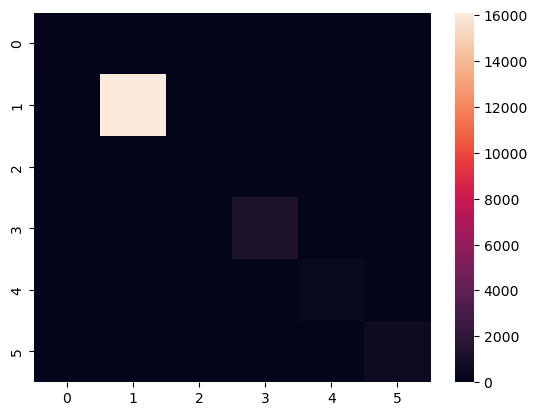

In [25]:
sns.heatmap(crosstab(list(true_labels.values), list(pred_labels.values)).count)

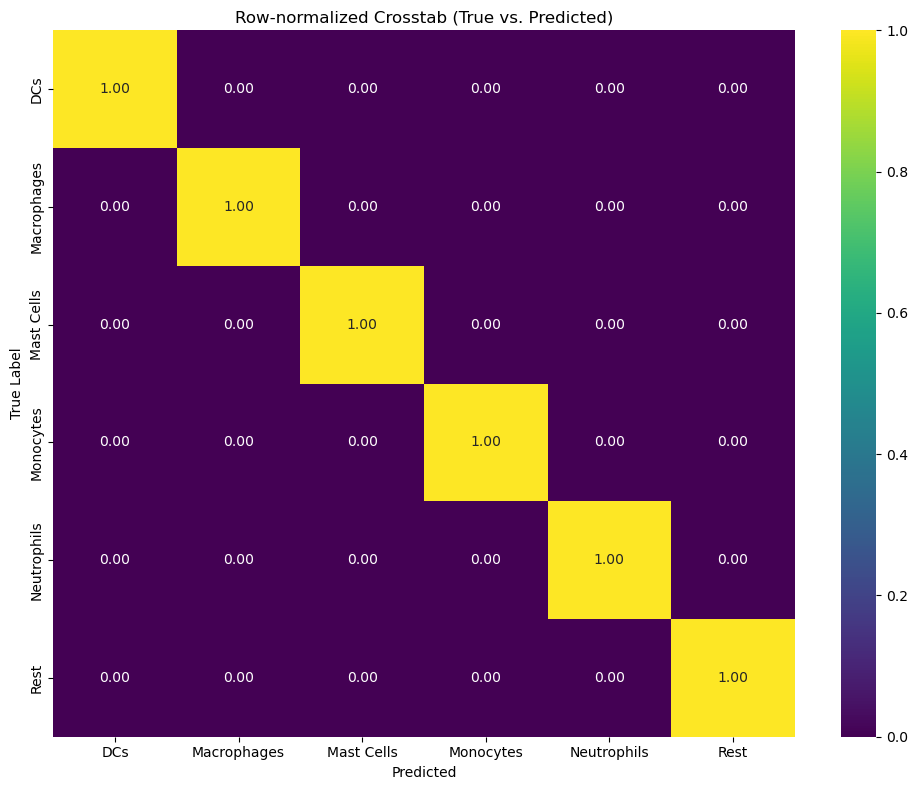

In [ ]:
# Row normalize the true labels to show the performance of classification for each class
ct_normalized = pd.crosstab(true_labels, pred_labels, normalize='index')

plt.figure(figsize=(10, 8))
sns.heatmap(ct_normalized, cmap='viridis', annot=True, fmt=".2f")
plt.title('Row-normalized Crosstab (True vs. Predicted)')
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()